# (12) Resume fit (GABAN)

**Motivation**: ...on GABAN <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_model

In [3]:
tr, meta = load_model(
    model_name='fixate1_k-40_z-420x[1]_enc(0x3)-dec(0x2)-pre(3x13)-post(3x12)',
    fit_name='ep160-b600-lr(0.002)_beta(0.9:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_05_11,09:31)',
    device='cuda',
)

In [4]:
epochs = range(meta['checkpoint'], tr.cfg.epochs)
epochs

range(80, 160)

In [10]:
tr.train(epochs=epochs)

gstep # 8.83e+04, nelbo: 3545953244952803.500, grad: inf:  10%| | 8/80 [1:36:48<


KeyboardInterrupt: 

In [2]:
# path = results_dir()
# path = pjoin(tmp_dir, 'trainer_analysis')
path = pjoin(tmp_dir, 'neural_analysis')

In [3]:
for src in os.listdir(path):
    parts = src.split('_')
    try:
        i = next(
            i for i, e in
            enumerate(parts)
            if 'beta' in e
        )
    except StopIteration:
        print(f"skipped: {src}\n")
        continue
    beta = parts[i].split('-')[1]
    beta = f"beta-{float(beta)}"
    dst = '_'.join([
        beta if i == j else e for
        j, e in enumerate(parts)
    ])
    if src != dst:
        os.rename(
            src=pjoin(path, src),
            dst=pjoin(path, dst),
        )
        print(f"src = {src},\ndst = {dst}\n")

In [13]:
len(sorted(os.listdir(path)))

20

## AE

In [2]:
from ae.train_ae import TrainerAE, ConfigTrainAE
from ae.ae2d import AE, ConfigAE

In [3]:
ae = AE(ConfigAE(sim='fixate1', save=False))
tr = TrainerAE(ae, ConfigTrainAE(), device='cuda:1')

In [4]:
ae.print()

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|      AE      |  21.7 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |   96.0 K   |
|  enc_tower   |  13.9 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  1.3 Mil   |
|    expand    |  351.2 K   |
|  dec_tower   |  5.9 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

In [5]:
msg = ', '.join([
    f"# enc ftrs: {sum(ae.ftr_sizes()[0].values())}",
    f"# conv layers: {len(ae.all_conv_layers)}",
    f"# latents: {ae.cfg.total_latents()}",
])
print('\n', msg)
ae.print()
msg = '\n'.join([
    f"AE:\t\t{ae.cfg.name()}",
    f"Trainer:\t{tr.cfg.name()}\n",
])
print(msg)

# enc ftrs: 5056, # conv layers: 198, # latents: 420

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|      AE      |  21.7 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |   96.0 K   |
|  enc_tower   |  13.9 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  1.3 Mil   |
|    expand    |  351.2 K   |
|  dec_tower   |  5.9 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

AE:             terrain8_k-32_h-20x[3,6,12]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
Trainer:        ep160-b600-lr(0.002)_beta-ae_lamb(0.001)_gr(250)

In [6]:
x, _ = next(iter(tr.dl_tst))

In [8]:
y, z = ae(x)

In [10]:
y.shape

torch.Size([600, 2, 17, 17])

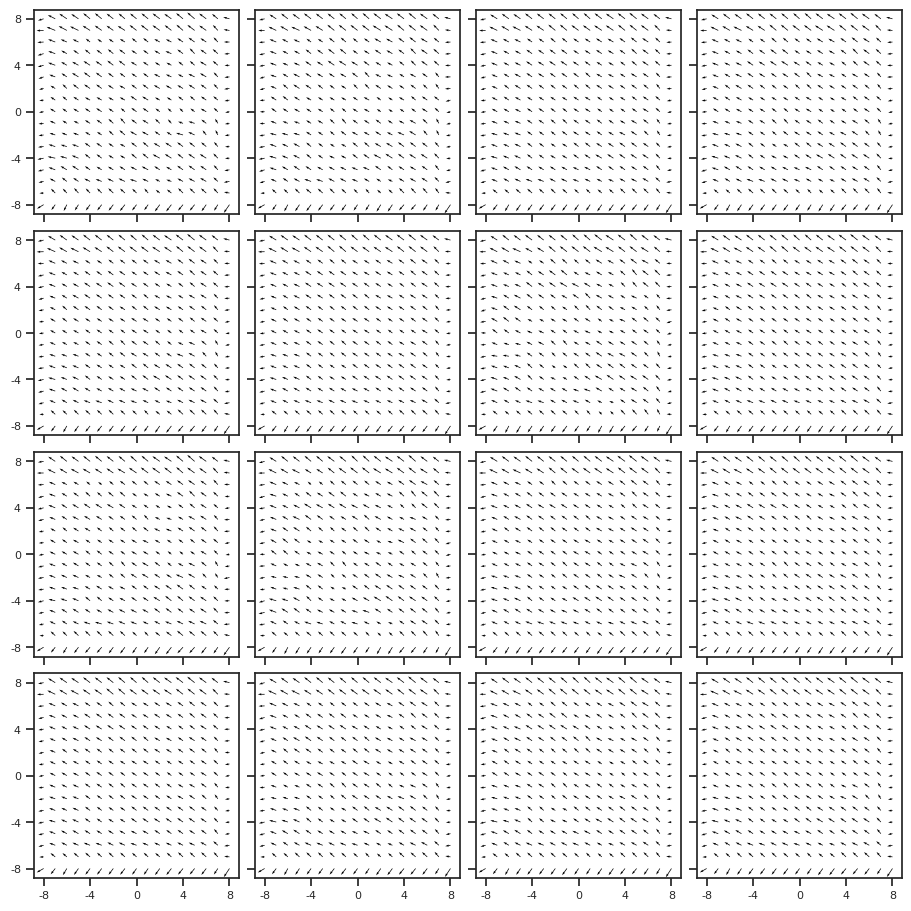

In [12]:
show_opticflow(y);

## Vanilla specs

In [2]:
vae = VAE(ConfigVAE(
    sim='fixate1', save=False,
    n_ch=40, n_latent_scales=1, n_latent_per_group=420, n_groups_per_scale=1,
    n_enc_cells=0, n_enc_nodes=3, n_dec_cells=0, n_dec_nodes=2, n_pre_blocks=3,
    n_pre_cells=13, n_post_blocks=3, n_post_cells=12,
))
tr = TrainerVAE(vae, ConfigTrainVAE(), device='cuda')

In [3]:
vae.print()

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  23.5 Mil  |
|     ---      |    ---     |
|     stem     |    400     |
| pre_process  |  14.1 Mil  |
|     enc0     |  103.0 K   |
| enc_sampler  |  1.1 Mil   |
| stem_decoder |  538.2 K   |
| post_process |  7.7 Mil   |
|     out      |    722     |
+--------------+------------+

In [4]:
sizes = collections.defaultdict(int)
for p in vae.parameters():
    sizes[p.size()] += 1
    if p.grad is None:
        print(p.size())
sizes = dict(sizes)

torch.Size([40, 2, 2, 2])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([20, 40, 1, 1])

torch.Size([20])

torch.Size([20])

torch.Size([20, 40, 1, 1])

torch.Size([20])

torch.Size([20])

torch.Size([20, 40, 1, 1])

torch.Size([20])

torch.Size([20])

torch.Size([20, 40, 1, 1])

torch.Size([20])

torch.Size([20])

torch.Size([80, 40, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([40, 80, 1, 1])

torch.Size([40])

torch.Size([40])

torch.Size([40, 80, 1, 1])

torch.Size([40])

torch.Size([40])

torch.Size([40, 80, 1, 1])

torch.Size([40])

torch.Size([40])

torch.Size([40, 80, 1, 1])

torch.Size([40])

torch.Size([40])

torch.Size([160, 80, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([80, 160, 1, 1])

torch.Size([80])

torch.Size([80])

torch.Size([80, 160, 1, 1])

torch.Size([80])

torch.Size([80])

torch.Size([80, 160, 1, 1])

torch.Size([80])

torch.Size([80])

torch.Size([80, 160, 1, 1])

torch.Size([80])

torch.Size([80])

torch.Size([320, 160, 3, 3])

torch.Size([320])

torch.Size([320])

torch.Size([320, 320, 3, 3])

torch.Size([320])

torch.Size([320])

torch.Size([320, 320, 3, 3])

torch.Size([320])

torch.Size([320])

torch.Size([20, 320])

torch.Size([20])

torch.Size([320, 20])

torch.Size([320])

torch.Size([320, 320, 1, 1])

torch.Size([320])

torch.Size([320])

torch.Size([840, 320, 2, 2])

torch.Size([840])

torch.Size([840])

torch.Size([420, 320, 2, 2])

torch.Size([320])

torch.Size([320])

torch.Size([160, 320, 1, 1])

torch.Size([160])

torch.Size([160])

torch.Size([160, 320, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([160, 160, 3, 3])

torch.Size([160])

torch.Size([160])

torch.Size([10, 160])

torch.Size([10])

torch.Size([160, 10])

torch.Size([160])

torch.Size([80, 160, 1, 1])

torch.Size([80])

torch.Size([80])

torch.Size([80, 160, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([80, 80, 3, 3])

torch.Size([80])

torch.Size([80])

torch.Size([5, 80])

torch.Size([5])

torch.Size([80, 5])

torch.Size([80])

torch.Size([40, 80, 1, 1])

torch.Size([40])

torch.Size([40])

torch.Size([40, 80, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([40, 40, 3, 3])

torch.Size([40])

torch.Size([40])

torch.Size([4, 40])

torch.Size([4])

torch.Size([40, 4])

torch.Size([40])

torch.Size([2, 40, 3, 3])

torch.Size([2])

In [5]:
print(sizes)

{
    torch.Size([40, 2, 2, 2]): 1,
    torch.Size([40]): 156,
    torch.Size([40, 40, 3, 3]): 59,
    torch.Size([4, 40]): 24,
    torch.Size([4]): 24,
    torch.Size([40, 4]): 24,
    torch.Size([20, 40, 1, 1]): 4,
    torch.Size([20]): 9,
    torch.Size([80, 40, 3, 3]): 1,
    torch.Size([80]): 161,
    torch.Size([80, 80, 3, 3]): 61,
    torch.Size([5, 80]): 25,
    torch.Size([5]): 25,
    torch.Size([80, 5]): 25,
    torch.Size([40, 80, 1, 1]): 5,
    torch.Size([160, 80, 3, 3]): 1,
    torch.Size([160]): 153,
    torch.Size([160, 160, 3, 3]): 61,
    torch.Size([10, 160]): 25,
    torch.Size([10]): 25,
    torch.Size([160, 10]): 25,
    torch.Size([80, 160, 1, 1]): 5,
    torch.Size([320, 160, 3, 3]): 1,
    torch.Size([320]): 11,
    torch.Size([320, 320, 3, 3]): 2,
    torch.Size([20, 320]): 1,
    torch.Size([320, 20]): 1,
    torch.Size([320, 320, 1, 1]): 1,
    torch.Size([840, 320, 2, 2]): 1,
    torch.Size([840]): 2,
    torch.Size([420, 320, 2, 2]): 1,
    torch.Size([160, 320, 1, 1]): 1,
    torch.Size([160, 320, 3, 3]): 1,
    torch.Size([80, 160, 3, 3]): 1,
    torch.Size([40, 80, 3, 3]): 1,
    torch.Size([2, 40, 3, 3]): 1,
    torch.Size([2]): 1
}

In [6]:
for p in vae.parameters():
    if not p.requires_grad:
        print(p.size())

In [7]:
for name, p in vae.named_parameters():
    if p.grad is None:
        print(name, p.size())

stem.weight
torch.Size([40, 2, 2, 2])

stem.bias
torch.Size([40])

stem.lognorm
torch.Size([40])

pre_process.0.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.0.ops.0.conv.bias
torch.Size([40])

pre_process.0.ops.0.conv.lognorm
torch.Size([40])

pre_process.0.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.0.ops.1.conv.bias
torch.Size([40])

pre_process.0.ops.1.conv.lognorm
torch.Size([40])

pre_process.0.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.0.ops.2.conv.bias
torch.Size([40])

pre_process.0.ops.2.conv.lognorm
torch.Size([40])

pre_process.0.se.fc.0.weight
torch.Size([4, 40])

pre_process.0.se.fc.0.bias
torch.Size([4])

pre_process.0.se.fc.2.weight
torch.Size([40, 4])

pre_process.0.se.fc.2.bias
torch.Size([40])

pre_process.1.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.1.ops.0.conv.bias
torch.Size([40])

pre_process.1.ops.0.conv.lognorm
torch.Size([40])

pre_process.1.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.1.ops.1.conv.bias
torch.Size([40])

pre_process.1.ops.1.conv.lognorm
torch.Size([40])

pre_process.1.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.1.ops.2.conv.bias
torch.Size([40])

pre_process.1.ops.2.conv.lognorm
torch.Size([40])

pre_process.1.se.fc.0.weight
torch.Size([4, 40])

pre_process.1.se.fc.0.bias
torch.Size([4])

pre_process.1.se.fc.2.weight
torch.Size([40, 4])

pre_process.1.se.fc.2.bias
torch.Size([40])

pre_process.2.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.2.ops.0.conv.bias
torch.Size([40])

pre_process.2.ops.0.conv.lognorm
torch.Size([40])

pre_process.2.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.2.ops.1.conv.bias
torch.Size([40])

pre_process.2.ops.1.conv.lognorm
torch.Size([40])

pre_process.2.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.2.ops.2.conv.bias
torch.Size([40])

pre_process.2.ops.2.conv.lognorm
torch.Size([40])

pre_process.2.se.fc.0.weight
torch.Size([4, 40])

pre_process.2.se.fc.0.bias
torch.Size([4])

pre_process.2.se.fc.2.weight
torch.Size([40, 4])

pre_process.2.se.fc.2.bias
torch.Size([40])

pre_process.3.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.3.ops.0.conv.bias
torch.Size([40])

pre_process.3.ops.0.conv.lognorm
torch.Size([40])

pre_process.3.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.3.ops.1.conv.bias
torch.Size([40])

pre_process.3.ops.1.conv.lognorm
torch.Size([40])

pre_process.3.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.3.ops.2.conv.bias
torch.Size([40])

pre_process.3.ops.2.conv.lognorm
torch.Size([40])

pre_process.3.se.fc.0.weight
torch.Size([4, 40])

pre_process.3.se.fc.0.bias
torch.Size([4])

pre_process.3.se.fc.2.weight
torch.Size([40, 4])

pre_process.3.se.fc.2.bias
torch.Size([40])

pre_process.4.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.4.ops.0.conv.bias
torch.Size([40])

pre_process.4.ops.0.conv.lognorm
torch.Size([40])

pre_process.4.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.4.ops.1.conv.bias
torch.Size([40])

pre_process.4.ops.1.conv.lognorm
torch.Size([40])

pre_process.4.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.4.ops.2.conv.bias
torch.Size([40])

pre_process.4.ops.2.conv.lognorm
torch.Size([40])

pre_process.4.se.fc.0.weight
torch.Size([4, 40])

pre_process.4.se.fc.0.bias
torch.Size([4])

pre_process.4.se.fc.2.weight
torch.Size([40, 4])

pre_process.4.se.fc.2.bias
torch.Size([40])

pre_process.5.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.5.ops.0.conv.bias
torch.Size([40])

pre_process.5.ops.0.conv.lognorm
torch.Size([40])

pre_process.5.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.5.ops.1.conv.bias
torch.Size([40])

pre_process.5.ops.1.conv.lognorm
torch.Size([40])

pre_process.5.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.5.ops.2.conv.bias
torch.Size([40])

pre_process.5.ops.2.conv.lognorm
torch.Size([40])

pre_process.5.se.fc.0.weight
torch.Size([4, 40])

pre_process.5.se.fc.0.bias
torch.Size([4])

pre_process.5.se.fc.2.weight
torch.Size([40, 4])

pre_process.5.se.fc.2.bias
torch.Size([40])

pre_process.6.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.6.ops.0.conv.bias
torch.Size([40])

pre_process.6.ops.0.conv.lognorm
torch.Size([40])

pre_process.6.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.6.ops.1.conv.bias
torch.Size([40])

pre_process.6.ops.1.conv.lognorm
torch.Size([40])

pre_process.6.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.6.ops.2.conv.bias
torch.Size([40])

pre_process.6.ops.2.conv.lognorm
torch.Size([40])

pre_process.6.se.fc.0.weight
torch.Size([4, 40])

pre_process.6.se.fc.0.bias
torch.Size([4])

pre_process.6.se.fc.2.weight
torch.Size([40, 4])

pre_process.6.se.fc.2.bias
torch.Size([40])

pre_process.7.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.7.ops.0.conv.bias
torch.Size([40])

pre_process.7.ops.0.conv.lognorm
torch.Size([40])

pre_process.7.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.7.ops.1.conv.bias
torch.Size([40])

pre_process.7.ops.1.conv.lognorm
torch.Size([40])

pre_process.7.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.7.ops.2.conv.bias
torch.Size([40])

pre_process.7.ops.2.conv.lognorm
torch.Size([40])

pre_process.7.se.fc.0.weight
torch.Size([4, 40])

pre_process.7.se.fc.0.bias
torch.Size([4])

pre_process.7.se.fc.2.weight
torch.Size([40, 4])

pre_process.7.se.fc.2.bias
torch.Size([40])

pre_process.8.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.8.ops.0.conv.bias
torch.Size([40])

pre_process.8.ops.0.conv.lognorm
torch.Size([40])

pre_process.8.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.8.ops.1.conv.bias
torch.Size([40])

pre_process.8.ops.1.conv.lognorm
torch.Size([40])

pre_process.8.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.8.ops.2.conv.bias
torch.Size([40])

pre_process.8.ops.2.conv.lognorm
torch.Size([40])

pre_process.8.se.fc.0.weight
torch.Size([4, 40])

pre_process.8.se.fc.0.bias
torch.Size([4])

pre_process.8.se.fc.2.weight
torch.Size([40, 4])

pre_process.8.se.fc.2.bias
torch.Size([40])

pre_process.9.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.9.ops.0.conv.bias
torch.Size([40])

pre_process.9.ops.0.conv.lognorm
torch.Size([40])

pre_process.9.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.9.ops.1.conv.bias
torch.Size([40])

pre_process.9.ops.1.conv.lognorm
torch.Size([40])

pre_process.9.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.9.ops.2.conv.bias
torch.Size([40])

pre_process.9.ops.2.conv.lognorm
torch.Size([40])

pre_process.9.se.fc.0.weight
torch.Size([4, 40])

pre_process.9.se.fc.0.bias
torch.Size([4])

pre_process.9.se.fc.2.weight
torch.Size([40, 4])

pre_process.9.se.fc.2.bias
torch.Size([40])

pre_process.10.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.10.ops.0.conv.bias
torch.Size([40])

pre_process.10.ops.0.conv.lognorm
torch.Size([40])

pre_process.10.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.10.ops.1.conv.bias
torch.Size([40])

pre_process.10.ops.1.conv.lognorm
torch.Size([40])

pre_process.10.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.10.ops.2.conv.bias
torch.Size([40])

pre_process.10.ops.2.conv.lognorm
torch.Size([40])

pre_process.10.se.fc.0.weight
torch.Size([4, 40])

pre_process.10.se.fc.0.bias
torch.Size([4])

pre_process.10.se.fc.2.weight
torch.Size([40, 4])

pre_process.10.se.fc.2.bias
torch.Size([40])

pre_process.11.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.11.ops.0.conv.bias
torch.Size([40])

pre_process.11.ops.0.conv.lognorm
torch.Size([40])

pre_process.11.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.11.ops.1.conv.bias
torch.Size([40])

pre_process.11.ops.1.conv.lognorm
torch.Size([40])

pre_process.11.ops.2.conv.weight
torch.Size([40, 40, 3, 3])

pre_process.11.ops.2.conv.bias
torch.Size([40])

pre_process.11.ops.2.conv.lognorm
torch.Size([40])

pre_process.11.se.fc.0.weight
torch.Size([4, 40])

pre_process.11.se.fc.0.bias
torch.Size([4])

pre_process.11.se.fc.2.weight
torch.Size([40, 4])

pre_process.11.se.fc.2.bias
torch.Size([40])

pre_process.12.skip.ops.0.weight
torch.Size([20, 40, 1, 1])

pre_process.12.skip.ops.0.bias
torch.Size([20])

pre_process.12.skip.ops.0.lognorm
torch.Size([20])

pre_process.12.skip.ops.1.weight
torch.Size([20, 40, 1, 1])

pre_process.12.skip.ops.1.bias
torch.Size([20])

pre_process.12.skip.ops.1.lognorm
torch.Size([20])

pre_process.12.skip.ops.2.weight
torch.Size([20, 40, 1, 1])

pre_process.12.skip.ops.2.bias
torch.Size([20])

pre_process.12.skip.ops.2.lognorm
torch.Size([20])

pre_process.12.skip.ops.3.weight
torch.Size([20, 40, 1, 1])

pre_process.12.skip.ops.3.bias
torch.Size([20])

pre_process.12.skip.ops.3.lognorm
torch.Size([20])

pre_process.12.ops.0.conv.weight
torch.Size([80, 40, 3, 3])

pre_process.12.ops.0.conv.bias
torch.Size([80])

pre_process.12.ops.0.conv.lognorm
torch.Size([80])

pre_process.12.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.12.ops.1.conv.bias
torch.Size([80])

pre_process.12.ops.1.conv.lognorm
torch.Size([80])

pre_process.12.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.12.ops.2.conv.bias
torch.Size([80])

pre_process.12.ops.2.conv.lognorm
torch.Size([80])

pre_process.12.se.fc.0.weight
torch.Size([5, 80])

pre_process.12.se.fc.0.bias
torch.Size([5])

pre_process.12.se.fc.2.weight
torch.Size([80, 5])

pre_process.12.se.fc.2.bias
torch.Size([80])

pre_process.13.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.13.ops.0.conv.bias
torch.Size([80])

pre_process.13.ops.0.conv.lognorm
torch.Size([80])

pre_process.13.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.13.ops.1.conv.bias
torch.Size([80])

pre_process.13.ops.1.conv.lognorm
torch.Size([80])

pre_process.13.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.13.ops.2.conv.bias
torch.Size([80])

pre_process.13.ops.2.conv.lognorm
torch.Size([80])

pre_process.13.se.fc.0.weight
torch.Size([5, 80])

pre_process.13.se.fc.0.bias
torch.Size([5])

pre_process.13.se.fc.2.weight
torch.Size([80, 5])

pre_process.13.se.fc.2.bias
torch.Size([80])

pre_process.14.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.14.ops.0.conv.bias
torch.Size([80])

pre_process.14.ops.0.conv.lognorm
torch.Size([80])

pre_process.14.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.14.ops.1.conv.bias
torch.Size([80])

pre_process.14.ops.1.conv.lognorm
torch.Size([80])

pre_process.14.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.14.ops.2.conv.bias
torch.Size([80])

pre_process.14.ops.2.conv.lognorm
torch.Size([80])

pre_process.14.se.fc.0.weight
torch.Size([5, 80])

pre_process.14.se.fc.0.bias
torch.Size([5])

pre_process.14.se.fc.2.weight
torch.Size([80, 5])

pre_process.14.se.fc.2.bias
torch.Size([80])

pre_process.15.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.15.ops.0.conv.bias
torch.Size([80])

pre_process.15.ops.0.conv.lognorm
torch.Size([80])

pre_process.15.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.15.ops.1.conv.bias
torch.Size([80])

pre_process.15.ops.1.conv.lognorm
torch.Size([80])

pre_process.15.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.15.ops.2.conv.bias
torch.Size([80])

pre_process.15.ops.2.conv.lognorm
torch.Size([80])

pre_process.15.se.fc.0.weight
torch.Size([5, 80])

pre_process.15.se.fc.0.bias
torch.Size([5])

pre_process.15.se.fc.2.weight
torch.Size([80, 5])

pre_process.15.se.fc.2.bias
torch.Size([80])

pre_process.16.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.16.ops.0.conv.bias
torch.Size([80])

pre_process.16.ops.0.conv.lognorm
torch.Size([80])

pre_process.16.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.16.ops.1.conv.bias
torch.Size([80])

pre_process.16.ops.1.conv.lognorm
torch.Size([80])

pre_process.16.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.16.ops.2.conv.bias
torch.Size([80])

pre_process.16.ops.2.conv.lognorm
torch.Size([80])

pre_process.16.se.fc.0.weight
torch.Size([5, 80])

pre_process.16.se.fc.0.bias
torch.Size([5])

pre_process.16.se.fc.2.weight
torch.Size([80, 5])

pre_process.16.se.fc.2.bias
torch.Size([80])

pre_process.17.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.17.ops.0.conv.bias
torch.Size([80])

pre_process.17.ops.0.conv.lognorm
torch.Size([80])

pre_process.17.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.17.ops.1.conv.bias
torch.Size([80])

pre_process.17.ops.1.conv.lognorm
torch.Size([80])

pre_process.17.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.17.ops.2.conv.bias
torch.Size([80])

pre_process.17.ops.2.conv.lognorm
torch.Size([80])

pre_process.17.se.fc.0.weight
torch.Size([5, 80])

pre_process.17.se.fc.0.bias
torch.Size([5])

pre_process.17.se.fc.2.weight
torch.Size([80, 5])

pre_process.17.se.fc.2.bias
torch.Size([80])

pre_process.18.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.18.ops.0.conv.bias
torch.Size([80])

pre_process.18.ops.0.conv.lognorm
torch.Size([80])

pre_process.18.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.18.ops.1.conv.bias
torch.Size([80])

pre_process.18.ops.1.conv.lognorm
torch.Size([80])

pre_process.18.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.18.ops.2.conv.bias
torch.Size([80])

pre_process.18.ops.2.conv.lognorm
torch.Size([80])

pre_process.18.se.fc.0.weight
torch.Size([5, 80])

pre_process.18.se.fc.0.bias
torch.Size([5])

pre_process.18.se.fc.2.weight
torch.Size([80, 5])

pre_process.18.se.fc.2.bias
torch.Size([80])

pre_process.19.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.19.ops.0.conv.bias
torch.Size([80])

pre_process.19.ops.0.conv.lognorm
torch.Size([80])

pre_process.19.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.19.ops.1.conv.bias
torch.Size([80])

pre_process.19.ops.1.conv.lognorm
torch.Size([80])

pre_process.19.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.19.ops.2.conv.bias
torch.Size([80])

pre_process.19.ops.2.conv.lognorm
torch.Size([80])

pre_process.19.se.fc.0.weight
torch.Size([5, 80])

pre_process.19.se.fc.0.bias
torch.Size([5])

pre_process.19.se.fc.2.weight
torch.Size([80, 5])

pre_process.19.se.fc.2.bias
torch.Size([80])

pre_process.20.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.20.ops.0.conv.bias
torch.Size([80])

pre_process.20.ops.0.conv.lognorm
torch.Size([80])

pre_process.20.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.20.ops.1.conv.bias
torch.Size([80])

pre_process.20.ops.1.conv.lognorm
torch.Size([80])

pre_process.20.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.20.ops.2.conv.bias
torch.Size([80])

pre_process.20.ops.2.conv.lognorm
torch.Size([80])

pre_process.20.se.fc.0.weight
torch.Size([5, 80])

pre_process.20.se.fc.0.bias
torch.Size([5])

pre_process.20.se.fc.2.weight
torch.Size([80, 5])

pre_process.20.se.fc.2.bias
torch.Size([80])

pre_process.21.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.21.ops.0.conv.bias
torch.Size([80])

pre_process.21.ops.0.conv.lognorm
torch.Size([80])

pre_process.21.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.21.ops.1.conv.bias
torch.Size([80])

pre_process.21.ops.1.conv.lognorm
torch.Size([80])

pre_process.21.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.21.ops.2.conv.bias
torch.Size([80])

pre_process.21.ops.2.conv.lognorm
torch.Size([80])

pre_process.21.se.fc.0.weight
torch.Size([5, 80])

pre_process.21.se.fc.0.bias
torch.Size([5])

pre_process.21.se.fc.2.weight
torch.Size([80, 5])

pre_process.21.se.fc.2.bias
torch.Size([80])

pre_process.22.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.22.ops.0.conv.bias
torch.Size([80])

pre_process.22.ops.0.conv.lognorm
torch.Size([80])

pre_process.22.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.22.ops.1.conv.bias
torch.Size([80])

pre_process.22.ops.1.conv.lognorm
torch.Size([80])

pre_process.22.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.22.ops.2.conv.bias
torch.Size([80])

pre_process.22.ops.2.conv.lognorm
torch.Size([80])

pre_process.22.se.fc.0.weight
torch.Size([5, 80])

pre_process.22.se.fc.0.bias
torch.Size([5])

pre_process.22.se.fc.2.weight
torch.Size([80, 5])

pre_process.22.se.fc.2.bias
torch.Size([80])

pre_process.23.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.23.ops.0.conv.bias
torch.Size([80])

pre_process.23.ops.0.conv.lognorm
torch.Size([80])

pre_process.23.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.23.ops.1.conv.bias
torch.Size([80])

pre_process.23.ops.1.conv.lognorm
torch.Size([80])

pre_process.23.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.23.ops.2.conv.bias
torch.Size([80])

pre_process.23.ops.2.conv.lognorm
torch.Size([80])

pre_process.23.se.fc.0.weight
torch.Size([5, 80])

pre_process.23.se.fc.0.bias
torch.Size([5])

pre_process.23.se.fc.2.weight
torch.Size([80, 5])

pre_process.23.se.fc.2.bias
torch.Size([80])

pre_process.24.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.24.ops.0.conv.bias
torch.Size([80])

pre_process.24.ops.0.conv.lognorm
torch.Size([80])

pre_process.24.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.24.ops.1.conv.bias
torch.Size([80])

pre_process.24.ops.1.conv.lognorm
torch.Size([80])

pre_process.24.ops.2.conv.weight
torch.Size([80, 80, 3, 3])

pre_process.24.ops.2.conv.bias
torch.Size([80])

pre_process.24.ops.2.conv.lognorm
torch.Size([80])

pre_process.24.se.fc.0.weight
torch.Size([5, 80])

pre_process.24.se.fc.0.bias
torch.Size([5])

pre_process.24.se.fc.2.weight
torch.Size([80, 5])

pre_process.24.se.fc.2.bias
torch.Size([80])

pre_process.25.skip.ops.0.weight
torch.Size([40, 80, 1, 1])

pre_process.25.skip.ops.0.bias
torch.Size([40])

pre_process.25.skip.ops.0.lognorm
torch.Size([40])

pre_process.25.skip.ops.1.weight
torch.Size([40, 80, 1, 1])

pre_process.25.skip.ops.1.bias
torch.Size([40])

pre_process.25.skip.ops.1.lognorm
torch.Size([40])

pre_process.25.skip.ops.2.weight
torch.Size([40, 80, 1, 1])

pre_process.25.skip.ops.2.bias
torch.Size([40])

pre_process.25.skip.ops.2.lognorm
torch.Size([40])

pre_process.25.skip.ops.3.weight
torch.Size([40, 80, 1, 1])

pre_process.25.skip.ops.3.bias
torch.Size([40])

pre_process.25.skip.ops.3.lognorm
torch.Size([40])

pre_process.25.ops.0.conv.weight
torch.Size([160, 80, 3, 3])

pre_process.25.ops.0.conv.bias
torch.Size([160])

pre_process.25.ops.0.conv.lognorm
torch.Size([160])

pre_process.25.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.25.ops.1.conv.bias
torch.Size([160])

pre_process.25.ops.1.conv.lognorm
torch.Size([160])

pre_process.25.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.25.ops.2.conv.bias
torch.Size([160])

pre_process.25.ops.2.conv.lognorm
torch.Size([160])

pre_process.25.se.fc.0.weight
torch.Size([10, 160])

pre_process.25.se.fc.0.bias
torch.Size([10])

pre_process.25.se.fc.2.weight
torch.Size([160, 10])

pre_process.25.se.fc.2.bias
torch.Size([160])

pre_process.26.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.26.ops.0.conv.bias
torch.Size([160])

pre_process.26.ops.0.conv.lognorm
torch.Size([160])

pre_process.26.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.26.ops.1.conv.bias
torch.Size([160])

pre_process.26.ops.1.conv.lognorm
torch.Size([160])

pre_process.26.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.26.ops.2.conv.bias
torch.Size([160])

pre_process.26.ops.2.conv.lognorm
torch.Size([160])

pre_process.26.se.fc.0.weight
torch.Size([10, 160])

pre_process.26.se.fc.0.bias
torch.Size([10])

pre_process.26.se.fc.2.weight
torch.Size([160, 10])

pre_process.26.se.fc.2.bias
torch.Size([160])

pre_process.27.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.27.ops.0.conv.bias
torch.Size([160])

pre_process.27.ops.0.conv.lognorm
torch.Size([160])

pre_process.27.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.27.ops.1.conv.bias
torch.Size([160])

pre_process.27.ops.1.conv.lognorm
torch.Size([160])

pre_process.27.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.27.ops.2.conv.bias
torch.Size([160])

pre_process.27.ops.2.conv.lognorm
torch.Size([160])

pre_process.27.se.fc.0.weight
torch.Size([10, 160])

pre_process.27.se.fc.0.bias
torch.Size([10])

pre_process.27.se.fc.2.weight
torch.Size([160, 10])

pre_process.27.se.fc.2.bias
torch.Size([160])

pre_process.28.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.28.ops.0.conv.bias
torch.Size([160])

pre_process.28.ops.0.conv.lognorm
torch.Size([160])

pre_process.28.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.28.ops.1.conv.bias
torch.Size([160])

pre_process.28.ops.1.conv.lognorm
torch.Size([160])

pre_process.28.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.28.ops.2.conv.bias
torch.Size([160])

pre_process.28.ops.2.conv.lognorm
torch.Size([160])

pre_process.28.se.fc.0.weight
torch.Size([10, 160])

pre_process.28.se.fc.0.bias
torch.Size([10])

pre_process.28.se.fc.2.weight
torch.Size([160, 10])

pre_process.28.se.fc.2.bias
torch.Size([160])

pre_process.29.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.29.ops.0.conv.bias
torch.Size([160])

pre_process.29.ops.0.conv.lognorm
torch.Size([160])

pre_process.29.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.29.ops.1.conv.bias
torch.Size([160])

pre_process.29.ops.1.conv.lognorm
torch.Size([160])

pre_process.29.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.29.ops.2.conv.bias
torch.Size([160])

pre_process.29.ops.2.conv.lognorm
torch.Size([160])

pre_process.29.se.fc.0.weight
torch.Size([10, 160])

pre_process.29.se.fc.0.bias
torch.Size([10])

pre_process.29.se.fc.2.weight
torch.Size([160, 10])

pre_process.29.se.fc.2.bias
torch.Size([160])

pre_process.30.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.30.ops.0.conv.bias
torch.Size([160])

pre_process.30.ops.0.conv.lognorm
torch.Size([160])

pre_process.30.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.30.ops.1.conv.bias
torch.Size([160])

pre_process.30.ops.1.conv.lognorm
torch.Size([160])

pre_process.30.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.30.ops.2.conv.bias
torch.Size([160])

pre_process.30.ops.2.conv.lognorm
torch.Size([160])

pre_process.30.se.fc.0.weight
torch.Size([10, 160])

pre_process.30.se.fc.0.bias
torch.Size([10])

pre_process.30.se.fc.2.weight
torch.Size([160, 10])

pre_process.30.se.fc.2.bias
torch.Size([160])

pre_process.31.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.31.ops.0.conv.bias
torch.Size([160])

pre_process.31.ops.0.conv.lognorm
torch.Size([160])

pre_process.31.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.31.ops.1.conv.bias
torch.Size([160])

pre_process.31.ops.1.conv.lognorm
torch.Size([160])

pre_process.31.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.31.ops.2.conv.bias
torch.Size([160])

pre_process.31.ops.2.conv.lognorm
torch.Size([160])

pre_process.31.se.fc.0.weight
torch.Size([10, 160])

pre_process.31.se.fc.0.bias
torch.Size([10])

pre_process.31.se.fc.2.weight
torch.Size([160, 10])

pre_process.31.se.fc.2.bias
torch.Size([160])

pre_process.32.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.32.ops.0.conv.bias
torch.Size([160])

pre_process.32.ops.0.conv.lognorm
torch.Size([160])

pre_process.32.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.32.ops.1.conv.bias
torch.Size([160])

pre_process.32.ops.1.conv.lognorm
torch.Size([160])

pre_process.32.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.32.ops.2.conv.bias
torch.Size([160])

pre_process.32.ops.2.conv.lognorm
torch.Size([160])

pre_process.32.se.fc.0.weight
torch.Size([10, 160])

pre_process.32.se.fc.0.bias
torch.Size([10])

pre_process.32.se.fc.2.weight
torch.Size([160, 10])

pre_process.32.se.fc.2.bias
torch.Size([160])

pre_process.33.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.33.ops.0.conv.bias
torch.Size([160])

pre_process.33.ops.0.conv.lognorm
torch.Size([160])

pre_process.33.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.33.ops.1.conv.bias
torch.Size([160])

pre_process.33.ops.1.conv.lognorm
torch.Size([160])

pre_process.33.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.33.ops.2.conv.bias
torch.Size([160])

pre_process.33.ops.2.conv.lognorm
torch.Size([160])

pre_process.33.se.fc.0.weight
torch.Size([10, 160])

pre_process.33.se.fc.0.bias
torch.Size([10])

pre_process.33.se.fc.2.weight
torch.Size([160, 10])

pre_process.33.se.fc.2.bias
torch.Size([160])

pre_process.34.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.34.ops.0.conv.bias
torch.Size([160])

pre_process.34.ops.0.conv.lognorm
torch.Size([160])

pre_process.34.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.34.ops.1.conv.bias
torch.Size([160])

pre_process.34.ops.1.conv.lognorm
torch.Size([160])

pre_process.34.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.34.ops.2.conv.bias
torch.Size([160])

pre_process.34.ops.2.conv.lognorm
torch.Size([160])

pre_process.34.se.fc.0.weight
torch.Size([10, 160])

pre_process.34.se.fc.0.bias
torch.Size([10])

pre_process.34.se.fc.2.weight
torch.Size([160, 10])

pre_process.34.se.fc.2.bias
torch.Size([160])

pre_process.35.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.35.ops.0.conv.bias
torch.Size([160])

pre_process.35.ops.0.conv.lognorm
torch.Size([160])

pre_process.35.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.35.ops.1.conv.bias
torch.Size([160])

pre_process.35.ops.1.conv.lognorm
torch.Size([160])

pre_process.35.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.35.ops.2.conv.bias
torch.Size([160])

pre_process.35.ops.2.conv.lognorm
torch.Size([160])

pre_process.35.se.fc.0.weight
torch.Size([10, 160])

pre_process.35.se.fc.0.bias
torch.Size([10])

pre_process.35.se.fc.2.weight
torch.Size([160, 10])

pre_process.35.se.fc.2.bias
torch.Size([160])

pre_process.36.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.36.ops.0.conv.bias
torch.Size([160])

pre_process.36.ops.0.conv.lognorm
torch.Size([160])

pre_process.36.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.36.ops.1.conv.bias
torch.Size([160])

pre_process.36.ops.1.conv.lognorm
torch.Size([160])

pre_process.36.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.36.ops.2.conv.bias
torch.Size([160])

pre_process.36.ops.2.conv.lognorm
torch.Size([160])

pre_process.36.se.fc.0.weight
torch.Size([10, 160])

pre_process.36.se.fc.0.bias
torch.Size([10])

pre_process.36.se.fc.2.weight
torch.Size([160, 10])

pre_process.36.se.fc.2.bias
torch.Size([160])

pre_process.37.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.37.ops.0.conv.bias
torch.Size([160])

pre_process.37.ops.0.conv.lognorm
torch.Size([160])

pre_process.37.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.37.ops.1.conv.bias
torch.Size([160])

pre_process.37.ops.1.conv.lognorm
torch.Size([160])

pre_process.37.ops.2.conv.weight
torch.Size([160, 160, 3, 3])

pre_process.37.ops.2.conv.bias
torch.Size([160])

pre_process.37.ops.2.conv.lognorm
torch.Size([160])

pre_process.37.se.fc.0.weight
torch.Size([10, 160])

pre_process.37.se.fc.0.bias
torch.Size([10])

pre_process.37.se.fc.2.weight
torch.Size([160, 10])

pre_process.37.se.fc.2.bias
torch.Size([160])

pre_process.38.skip.ops.0.weight
torch.Size([80, 160, 1, 1])

pre_process.38.skip.ops.0.bias
torch.Size([80])

pre_process.38.skip.ops.0.lognorm
torch.Size([80])

pre_process.38.skip.ops.1.weight
torch.Size([80, 160, 1, 1])

pre_process.38.skip.ops.1.bias
torch.Size([80])

pre_process.38.skip.ops.1.lognorm
torch.Size([80])

pre_process.38.skip.ops.2.weight
torch.Size([80, 160, 1, 1])

pre_process.38.skip.ops.2.bias
torch.Size([80])

pre_process.38.skip.ops.2.lognorm
torch.Size([80])

pre_process.38.skip.ops.3.weight
torch.Size([80, 160, 1, 1])

pre_process.38.skip.ops.3.bias
torch.Size([80])

pre_process.38.skip.ops.3.lognorm
torch.Size([80])

pre_process.38.ops.0.conv.weight
torch.Size([320, 160, 3, 3])

pre_process.38.ops.0.conv.bias
torch.Size([320])

pre_process.38.ops.0.conv.lognorm
torch.Size([320])

pre_process.38.ops.1.conv.weight
torch.Size([320, 320, 3, 3])

pre_process.38.ops.1.conv.bias
torch.Size([320])

pre_process.38.ops.1.conv.lognorm
torch.Size([320])

pre_process.38.ops.2.conv.weight
torch.Size([320, 320, 3, 3])

pre_process.38.ops.2.conv.bias
torch.Size([320])

pre_process.38.ops.2.conv.lognorm
torch.Size([320])

pre_process.38.se.fc.0.weight
torch.Size([20, 320])

pre_process.38.se.fc.0.bias
torch.Size([20])

pre_process.38.se.fc.2.weight
torch.Size([320, 20])

pre_process.38.se.fc.2.bias
torch.Size([320])

enc0.1.weight
torch.Size([320, 320, 1, 1])

enc0.1.bias
torch.Size([320])

enc0.1.lognorm
torch.Size([320])

enc_sampler.0.conv.weight
torch.Size([840, 320, 2, 2])

enc_sampler.0.conv.bias
torch.Size([840])

enc_sampler.0.conv.lognorm
torch.Size([840])

stem_decoder.weight
torch.Size([420, 320, 2, 2])

stem_decoder.bias
torch.Size([320])

stem_decoder.lognorm
torch.Size([320])

post_process.0.skip.1.weight
torch.Size([160, 320, 1, 1])

post_process.0.skip.1.bias
torch.Size([160])

post_process.0.skip.1.lognorm
torch.Size([160])

post_process.0.ops.0.conv.weight
torch.Size([160, 320, 3, 3])

post_process.0.ops.0.conv.bias
torch.Size([160])

post_process.0.ops.0.conv.lognorm
torch.Size([160])

post_process.0.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.0.ops.1.conv.bias
torch.Size([160])

post_process.0.ops.1.conv.lognorm
torch.Size([160])

post_process.0.se.fc.0.weight
torch.Size([10, 160])

post_process.0.se.fc.0.bias
torch.Size([10])

post_process.0.se.fc.2.weight
torch.Size([160, 10])

post_process.0.se.fc.2.bias
torch.Size([160])

post_process.1.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.1.ops.0.conv.bias
torch.Size([160])

post_process.1.ops.0.conv.lognorm
torch.Size([160])

post_process.1.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.1.ops.1.conv.bias
torch.Size([160])

post_process.1.ops.1.conv.lognorm
torch.Size([160])

post_process.1.se.fc.0.weight
torch.Size([10, 160])

post_process.1.se.fc.0.bias
torch.Size([10])

post_process.1.se.fc.2.weight
torch.Size([160, 10])

post_process.1.se.fc.2.bias
torch.Size([160])

post_process.2.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.2.ops.0.conv.bias
torch.Size([160])

post_process.2.ops.0.conv.lognorm
torch.Size([160])

post_process.2.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.2.ops.1.conv.bias
torch.Size([160])

post_process.2.ops.1.conv.lognorm
torch.Size([160])

post_process.2.se.fc.0.weight
torch.Size([10, 160])

post_process.2.se.fc.0.bias
torch.Size([10])

post_process.2.se.fc.2.weight
torch.Size([160, 10])

post_process.2.se.fc.2.bias
torch.Size([160])

post_process.3.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.3.ops.0.conv.bias
torch.Size([160])

post_process.3.ops.0.conv.lognorm
torch.Size([160])

post_process.3.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.3.ops.1.conv.bias
torch.Size([160])

post_process.3.ops.1.conv.lognorm
torch.Size([160])

post_process.3.se.fc.0.weight
torch.Size([10, 160])

post_process.3.se.fc.0.bias
torch.Size([10])

post_process.3.se.fc.2.weight
torch.Size([160, 10])

post_process.3.se.fc.2.bias
torch.Size([160])

post_process.4.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.4.ops.0.conv.bias
torch.Size([160])

post_process.4.ops.0.conv.lognorm
torch.Size([160])

post_process.4.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.4.ops.1.conv.bias
torch.Size([160])

post_process.4.ops.1.conv.lognorm
torch.Size([160])

post_process.4.se.fc.0.weight
torch.Size([10, 160])

post_process.4.se.fc.0.bias
torch.Size([10])

post_process.4.se.fc.2.weight
torch.Size([160, 10])

post_process.4.se.fc.2.bias
torch.Size([160])

post_process.5.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.5.ops.0.conv.bias
torch.Size([160])

post_process.5.ops.0.conv.lognorm
torch.Size([160])

post_process.5.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.5.ops.1.conv.bias
torch.Size([160])

post_process.5.ops.1.conv.lognorm
torch.Size([160])

post_process.5.se.fc.0.weight
torch.Size([10, 160])

post_process.5.se.fc.0.bias
torch.Size([10])

post_process.5.se.fc.2.weight
torch.Size([160, 10])

post_process.5.se.fc.2.bias
torch.Size([160])

post_process.6.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.6.ops.0.conv.bias
torch.Size([160])

post_process.6.ops.0.conv.lognorm
torch.Size([160])

post_process.6.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.6.ops.1.conv.bias
torch.Size([160])

post_process.6.ops.1.conv.lognorm
torch.Size([160])

post_process.6.se.fc.0.weight
torch.Size([10, 160])

post_process.6.se.fc.0.bias
torch.Size([10])

post_process.6.se.fc.2.weight
torch.Size([160, 10])

post_process.6.se.fc.2.bias
torch.Size([160])

post_process.7.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.7.ops.0.conv.bias
torch.Size([160])

post_process.7.ops.0.conv.lognorm
torch.Size([160])

post_process.7.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.7.ops.1.conv.bias
torch.Size([160])

post_process.7.ops.1.conv.lognorm
torch.Size([160])

post_process.7.se.fc.0.weight
torch.Size([10, 160])

post_process.7.se.fc.0.bias
torch.Size([10])

post_process.7.se.fc.2.weight
torch.Size([160, 10])

post_process.7.se.fc.2.bias
torch.Size([160])

post_process.8.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.8.ops.0.conv.bias
torch.Size([160])

post_process.8.ops.0.conv.lognorm
torch.Size([160])

post_process.8.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.8.ops.1.conv.bias
torch.Size([160])

post_process.8.ops.1.conv.lognorm
torch.Size([160])

post_process.8.se.fc.0.weight
torch.Size([10, 160])

post_process.8.se.fc.0.bias
torch.Size([10])

post_process.8.se.fc.2.weight
torch.Size([160, 10])

post_process.8.se.fc.2.bias
torch.Size([160])

post_process.9.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.9.ops.0.conv.bias
torch.Size([160])

post_process.9.ops.0.conv.lognorm
torch.Size([160])

post_process.9.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.9.ops.1.conv.bias
torch.Size([160])

post_process.9.ops.1.conv.lognorm
torch.Size([160])

post_process.9.se.fc.0.weight
torch.Size([10, 160])

post_process.9.se.fc.0.bias
torch.Size([10])

post_process.9.se.fc.2.weight
torch.Size([160, 10])

post_process.9.se.fc.2.bias
torch.Size([160])

post_process.10.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.10.ops.0.conv.bias
torch.Size([160])

post_process.10.ops.0.conv.lognorm
torch.Size([160])

post_process.10.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.10.ops.1.conv.bias
torch.Size([160])

post_process.10.ops.1.conv.lognorm
torch.Size([160])

post_process.10.se.fc.0.weight
torch.Size([10, 160])

post_process.10.se.fc.0.bias
torch.Size([10])

post_process.10.se.fc.2.weight
torch.Size([160, 10])

post_process.10.se.fc.2.bias
torch.Size([160])

post_process.11.ops.0.conv.weight
torch.Size([160, 160, 3, 3])

post_process.11.ops.0.conv.bias
torch.Size([160])

post_process.11.ops.0.conv.lognorm
torch.Size([160])

post_process.11.ops.1.conv.weight
torch.Size([160, 160, 3, 3])

post_process.11.ops.1.conv.bias
torch.Size([160])

post_process.11.ops.1.conv.lognorm
torch.Size([160])

post_process.11.se.fc.0.weight
torch.Size([10, 160])

post_process.11.se.fc.0.bias
torch.Size([10])

post_process.11.se.fc.2.weight
torch.Size([160, 10])

post_process.11.se.fc.2.bias
torch.Size([160])

post_process.12.skip.1.weight
torch.Size([80, 160, 1, 1])

post_process.12.skip.1.bias
torch.Size([80])

post_process.12.skip.1.lognorm
torch.Size([80])

post_process.12.ops.0.conv.weight
torch.Size([80, 160, 3, 3])

post_process.12.ops.0.conv.bias
torch.Size([80])

post_process.12.ops.0.conv.lognorm
torch.Size([80])

post_process.12.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.12.ops.1.conv.bias
torch.Size([80])

post_process.12.ops.1.conv.lognorm
torch.Size([80])

post_process.12.se.fc.0.weight
torch.Size([5, 80])

post_process.12.se.fc.0.bias
torch.Size([5])

post_process.12.se.fc.2.weight
torch.Size([80, 5])

post_process.12.se.fc.2.bias
torch.Size([80])

post_process.13.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.13.ops.0.conv.bias
torch.Size([80])

post_process.13.ops.0.conv.lognorm
torch.Size([80])

post_process.13.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.13.ops.1.conv.bias
torch.Size([80])

post_process.13.ops.1.conv.lognorm
torch.Size([80])

post_process.13.se.fc.0.weight
torch.Size([5, 80])

post_process.13.se.fc.0.bias
torch.Size([5])

post_process.13.se.fc.2.weight
torch.Size([80, 5])

post_process.13.se.fc.2.bias
torch.Size([80])

post_process.14.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.14.ops.0.conv.bias
torch.Size([80])

post_process.14.ops.0.conv.lognorm
torch.Size([80])

post_process.14.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.14.ops.1.conv.bias
torch.Size([80])

post_process.14.ops.1.conv.lognorm
torch.Size([80])

post_process.14.se.fc.0.weight
torch.Size([5, 80])

post_process.14.se.fc.0.bias
torch.Size([5])

post_process.14.se.fc.2.weight
torch.Size([80, 5])

post_process.14.se.fc.2.bias
torch.Size([80])

post_process.15.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.15.ops.0.conv.bias
torch.Size([80])

post_process.15.ops.0.conv.lognorm
torch.Size([80])

post_process.15.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.15.ops.1.conv.bias
torch.Size([80])

post_process.15.ops.1.conv.lognorm
torch.Size([80])

post_process.15.se.fc.0.weight
torch.Size([5, 80])

post_process.15.se.fc.0.bias
torch.Size([5])

post_process.15.se.fc.2.weight
torch.Size([80, 5])

post_process.15.se.fc.2.bias
torch.Size([80])

post_process.16.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.16.ops.0.conv.bias
torch.Size([80])

post_process.16.ops.0.conv.lognorm
torch.Size([80])

post_process.16.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.16.ops.1.conv.bias
torch.Size([80])

post_process.16.ops.1.conv.lognorm
torch.Size([80])

post_process.16.se.fc.0.weight
torch.Size([5, 80])

post_process.16.se.fc.0.bias
torch.Size([5])

post_process.16.se.fc.2.weight
torch.Size([80, 5])

post_process.16.se.fc.2.bias
torch.Size([80])

post_process.17.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.17.ops.0.conv.bias
torch.Size([80])

post_process.17.ops.0.conv.lognorm
torch.Size([80])

post_process.17.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.17.ops.1.conv.bias
torch.Size([80])

post_process.17.ops.1.conv.lognorm
torch.Size([80])

post_process.17.se.fc.0.weight
torch.Size([5, 80])

post_process.17.se.fc.0.bias
torch.Size([5])

post_process.17.se.fc.2.weight
torch.Size([80, 5])

post_process.17.se.fc.2.bias
torch.Size([80])

post_process.18.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.18.ops.0.conv.bias
torch.Size([80])

post_process.18.ops.0.conv.lognorm
torch.Size([80])

post_process.18.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.18.ops.1.conv.bias
torch.Size([80])

post_process.18.ops.1.conv.lognorm
torch.Size([80])

post_process.18.se.fc.0.weight
torch.Size([5, 80])

post_process.18.se.fc.0.bias
torch.Size([5])

post_process.18.se.fc.2.weight
torch.Size([80, 5])

post_process.18.se.fc.2.bias
torch.Size([80])

post_process.19.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.19.ops.0.conv.bias
torch.Size([80])

post_process.19.ops.0.conv.lognorm
torch.Size([80])

post_process.19.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.19.ops.1.conv.bias
torch.Size([80])

post_process.19.ops.1.conv.lognorm
torch.Size([80])

post_process.19.se.fc.0.weight
torch.Size([5, 80])

post_process.19.se.fc.0.bias
torch.Size([5])

post_process.19.se.fc.2.weight
torch.Size([80, 5])

post_process.19.se.fc.2.bias
torch.Size([80])

post_process.20.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.20.ops.0.conv.bias
torch.Size([80])

post_process.20.ops.0.conv.lognorm
torch.Size([80])

post_process.20.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.20.ops.1.conv.bias
torch.Size([80])

post_process.20.ops.1.conv.lognorm
torch.Size([80])

post_process.20.se.fc.0.weight
torch.Size([5, 80])

post_process.20.se.fc.0.bias
torch.Size([5])

post_process.20.se.fc.2.weight
torch.Size([80, 5])

post_process.20.se.fc.2.bias
torch.Size([80])

post_process.21.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.21.ops.0.conv.bias
torch.Size([80])

post_process.21.ops.0.conv.lognorm
torch.Size([80])

post_process.21.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.21.ops.1.conv.bias
torch.Size([80])

post_process.21.ops.1.conv.lognorm
torch.Size([80])

post_process.21.se.fc.0.weight
torch.Size([5, 80])

post_process.21.se.fc.0.bias
torch.Size([5])

post_process.21.se.fc.2.weight
torch.Size([80, 5])

post_process.21.se.fc.2.bias
torch.Size([80])

post_process.22.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.22.ops.0.conv.bias
torch.Size([80])

post_process.22.ops.0.conv.lognorm
torch.Size([80])

post_process.22.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.22.ops.1.conv.bias
torch.Size([80])

post_process.22.ops.1.conv.lognorm
torch.Size([80])

post_process.22.se.fc.0.weight
torch.Size([5, 80])

post_process.22.se.fc.0.bias
torch.Size([5])

post_process.22.se.fc.2.weight
torch.Size([80, 5])

post_process.22.se.fc.2.bias
torch.Size([80])

post_process.23.ops.0.conv.weight
torch.Size([80, 80, 3, 3])

post_process.23.ops.0.conv.bias
torch.Size([80])

post_process.23.ops.0.conv.lognorm
torch.Size([80])

post_process.23.ops.1.conv.weight
torch.Size([80, 80, 3, 3])

post_process.23.ops.1.conv.bias
torch.Size([80])

post_process.23.ops.1.conv.lognorm
torch.Size([80])

post_process.23.se.fc.0.weight
torch.Size([5, 80])

post_process.23.se.fc.0.bias
torch.Size([5])

post_process.23.se.fc.2.weight
torch.Size([80, 5])

post_process.23.se.fc.2.bias
torch.Size([80])

post_process.24.skip.1.weight
torch.Size([40, 80, 1, 1])

post_process.24.skip.1.bias
torch.Size([40])

post_process.24.skip.1.lognorm
torch.Size([40])

post_process.24.ops.0.conv.weight
torch.Size([40, 80, 3, 3])

post_process.24.ops.0.conv.bias
torch.Size([40])

post_process.24.ops.0.conv.lognorm
torch.Size([40])

post_process.24.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.24.ops.1.conv.bias
torch.Size([40])

post_process.24.ops.1.conv.lognorm
torch.Size([40])

post_process.24.se.fc.0.weight
torch.Size([4, 40])

post_process.24.se.fc.0.bias
torch.Size([4])

post_process.24.se.fc.2.weight
torch.Size([40, 4])

post_process.24.se.fc.2.bias
torch.Size([40])

post_process.26.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.26.ops.0.conv.bias
torch.Size([40])

post_process.26.ops.0.conv.lognorm
torch.Size([40])

post_process.26.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.26.ops.1.conv.bias
torch.Size([40])

post_process.26.ops.1.conv.lognorm
torch.Size([40])

post_process.26.se.fc.0.weight
torch.Size([4, 40])

post_process.26.se.fc.0.bias
torch.Size([4])

post_process.26.se.fc.2.weight
torch.Size([40, 4])

post_process.26.se.fc.2.bias
torch.Size([40])

post_process.27.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.27.ops.0.conv.bias
torch.Size([40])

post_process.27.ops.0.conv.lognorm
torch.Size([40])

post_process.27.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.27.ops.1.conv.bias
torch.Size([40])

post_process.27.ops.1.conv.lognorm
torch.Size([40])

post_process.27.se.fc.0.weight
torch.Size([4, 40])

post_process.27.se.fc.0.bias
torch.Size([4])

post_process.27.se.fc.2.weight
torch.Size([40, 4])

post_process.27.se.fc.2.bias
torch.Size([40])

post_process.28.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.28.ops.0.conv.bias
torch.Size([40])

post_process.28.ops.0.conv.lognorm
torch.Size([40])

post_process.28.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.28.ops.1.conv.bias
torch.Size([40])

post_process.28.ops.1.conv.lognorm
torch.Size([40])

post_process.28.se.fc.0.weight
torch.Size([4, 40])

post_process.28.se.fc.0.bias
torch.Size([4])

post_process.28.se.fc.2.weight
torch.Size([40, 4])

post_process.28.se.fc.2.bias
torch.Size([40])

post_process.29.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.29.ops.0.conv.bias
torch.Size([40])

post_process.29.ops.0.conv.lognorm
torch.Size([40])

post_process.29.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.29.ops.1.conv.bias
torch.Size([40])

post_process.29.ops.1.conv.lognorm
torch.Size([40])

post_process.29.se.fc.0.weight
torch.Size([4, 40])

post_process.29.se.fc.0.bias
torch.Size([4])

post_process.29.se.fc.2.weight
torch.Size([40, 4])

post_process.29.se.fc.2.bias
torch.Size([40])

post_process.30.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.30.ops.0.conv.bias
torch.Size([40])

post_process.30.ops.0.conv.lognorm
torch.Size([40])

post_process.30.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.30.ops.1.conv.bias
torch.Size([40])

post_process.30.ops.1.conv.lognorm
torch.Size([40])

post_process.30.se.fc.0.weight
torch.Size([4, 40])

post_process.30.se.fc.0.bias
torch.Size([4])

post_process.30.se.fc.2.weight
torch.Size([40, 4])

post_process.30.se.fc.2.bias
torch.Size([40])

post_process.31.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.31.ops.0.conv.bias
torch.Size([40])

post_process.31.ops.0.conv.lognorm
torch.Size([40])

post_process.31.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.31.ops.1.conv.bias
torch.Size([40])

post_process.31.ops.1.conv.lognorm
torch.Size([40])

post_process.31.se.fc.0.weight
torch.Size([4, 40])

post_process.31.se.fc.0.bias
torch.Size([4])

post_process.31.se.fc.2.weight
torch.Size([40, 4])

post_process.31.se.fc.2.bias
torch.Size([40])

post_process.32.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.32.ops.0.conv.bias
torch.Size([40])

post_process.32.ops.0.conv.lognorm
torch.Size([40])

post_process.32.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.32.ops.1.conv.bias
torch.Size([40])

post_process.32.ops.1.conv.lognorm
torch.Size([40])

post_process.32.se.fc.0.weight
torch.Size([4, 40])

post_process.32.se.fc.0.bias
torch.Size([4])

post_process.32.se.fc.2.weight
torch.Size([40, 4])

post_process.32.se.fc.2.bias
torch.Size([40])

post_process.33.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.33.ops.0.conv.bias
torch.Size([40])

post_process.33.ops.0.conv.lognorm
torch.Size([40])

post_process.33.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.33.ops.1.conv.bias
torch.Size([40])

post_process.33.ops.1.conv.lognorm
torch.Size([40])

post_process.33.se.fc.0.weight
torch.Size([4, 40])

post_process.33.se.fc.0.bias
torch.Size([4])

post_process.33.se.fc.2.weight
torch.Size([40, 4])

post_process.33.se.fc.2.bias
torch.Size([40])

post_process.34.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.34.ops.0.conv.bias
torch.Size([40])

post_process.34.ops.0.conv.lognorm
torch.Size([40])

post_process.34.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.34.ops.1.conv.bias
torch.Size([40])

post_process.34.ops.1.conv.lognorm
torch.Size([40])

post_process.34.se.fc.0.weight
torch.Size([4, 40])

post_process.34.se.fc.0.bias
torch.Size([4])

post_process.34.se.fc.2.weight
torch.Size([40, 4])

post_process.34.se.fc.2.bias
torch.Size([40])

post_process.35.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.35.ops.0.conv.bias
torch.Size([40])

post_process.35.ops.0.conv.lognorm
torch.Size([40])

post_process.35.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.35.ops.1.conv.bias
torch.Size([40])

post_process.35.ops.1.conv.lognorm
torch.Size([40])

post_process.35.se.fc.0.weight
torch.Size([4, 40])

post_process.35.se.fc.0.bias
torch.Size([4])

post_process.35.se.fc.2.weight
torch.Size([40, 4])

post_process.35.se.fc.2.bias
torch.Size([40])

post_process.36.ops.0.conv.weight
torch.Size([40, 40, 3, 3])

post_process.36.ops.0.conv.bias
torch.Size([40])

post_process.36.ops.0.conv.lognorm
torch.Size([40])

post_process.36.ops.1.conv.weight
torch.Size([40, 40, 3, 3])

post_process.36.ops.1.conv.bias
torch.Size([40])

post_process.36.ops.1.conv.lognorm
torch.Size([40])

post_process.36.se.fc.0.weight
torch.Size([4, 40])

post_process.36.se.fc.0.bias
torch.Size([4])

post_process.36.se.fc.2.weight
torch.Size([40, 4])

post_process.36.se.fc.2.bias
torch.Size([40])

out.weight
torch.Size([2, 40, 3, 3])

out.bias
torch.Size([2])

In [8]:
tr.train()

gstep # 17, nelbo: 167.649, grad: 726.0:   0%|          | 0/200 [00:13<?, ?it/s]

KeyboardInterrupt



In [9]:
for group in tr.optim.param_groups:
    group

In [10]:
len(tr.optim.param_groups)

1

In [11]:
beta1, beta2 = group['betas']
eps = group['eps']

In [12]:
beta1, beta2, eps

(0.9, 0.999, 1e-08)

In [13]:
len(tr.optim.state)

926

In [14]:
len(group['params'])

926

In [15]:
group['params'][0].shape

torch.Size([40, 2, 2, 2])

In [18]:
tr.optim.state[group['params'][-1]]

{'step': 18,
 'exp_avg': tensor([-27.8521,  61.9834], device='cuda:0'),
 'exp_inf': tensor([49.1181, 94.8124], device='cuda:0')}

In [19]:
p.grad

tensor([-18.6566,  19.9806], device='cuda:0')

In [20]:
vae.print()

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  23.5 Mil  |
|     ---      |    ---     |
|     stem     |    400     |
| pre_process  |  14.1 Mil  |
|     enc0     |  103.0 K   |
| enc_sampler  |  1.1 Mil   |
| stem_decoder |  538.2 K   |
| post_process |  7.7 Mil   |
|     out      |    722     |
+--------------+------------+

In [21]:
for name, m in vae.named_children():
    for p in m.parameters():
        if p.grad is None:
            print(name, p.size())

In [23]:
for p in vae.parameters():
    if p.grad is None:
        print(p.size())

In [2]:
save_script_vae(
    device='cuda:1',
    sims=['fixate4', 'terrain8'],
    args=['--kl_beta 1.0 --dry_run'] * 2,
)

[PROGRESS] 'run_vae_kaba.txt' saved at
/home/hadi/Dropbox/git/_MTMST/scripts

In [2]:
path = results_dir()

In [6]:
print(sorted(os.listdir(path)))

[
    'fixate0_nf-80_(2023_04_28,22:46)',
    'fixate0_nf-80_beta-1_(2023_05_04,09:03)',
    'fixate1_nf-420_(2023_04_27,20:20)',
    'fixate1_nf-420_beta-0.6_(2023_04_30,20:36)',
    'fixate1_nf-420_beta-0.7_(2023_04_30,21:40)',
    'fixate1_nf-420_beta-1e+01_(2023_04_30,22:48)',
    'fixate2_nf-420_(2023_04_27,13:57)',
    'fixate2_nf-420_(2023_04_28,12:46)',
    'obj1_nf-140_beta-10_(2023_05_04,11:53)',
    'obj1_nf-140_beta-1_(2023_05_02,15:57)',
    'obj1_nf-280_beta-0.5_(2023_05_04,11:11)',
    'obj1_nf-280_beta-1_(2023_05_04,10:27)',
    'obj2_nf-280_(2023_05_01,07:39)',
    'reservoir_nf-420_(2023_04_27,18:40)',
    'terrain1_nf-210_(2023_04_27,12:50)',
    'terrain2_nf-420_(2023_04_28,15:15)',
    'terrain4_nf-420_(2023_04_28,14:08)',
    'terrain8_nf-420_(2023_04_26,22:51)',
    'transl0_nf-70_(2023_04_27,13:30)',
    'transl1_nf-420_beta-0.5_(2023_05_02,15:00)',
    'transl1_nf-420_beta-10_(2023_05_04,09:20)',
    'transl1_nf-420_beta-1_(2023_05_02,22:02)',
    'transl8_nf-420_(2023_04_30,07:48)'
]